# Creación del modelo de regresión

## Obtención y visualización de datos

#### Comenzaremos creando modelos de regresión lineal multivariable. Para ello, veremos que features son más influyentes para nuestra predicción, y posteriormente veremos si es o no necesario tratar previamente los datos para mejorar la predicción.

##### Importamos las librerías necesarias

In [0]:
import pandas as pd
import numpy as np

##### Importamos los datos post-procesados. Con ellos entrenaremos y testearemos nuestro modelo.

In [0]:
train_dataset = pd.read_csv('train_dataset.csv',sep=';')
test_dataset = pd.read_csv('test_dataset.csv',sep=';')

In [4]:
train_dataset.shape

(634941, 31)

In [5]:
test_dataset.shape

(158736, 31)

##### Analizamos la matríz del coeficiente de correlación de Pearson, entre las variables de entrada y las variables de salida. Donde podremos comprobar que los valores que las características que más inciden en el resultado final son: "Global_Radiation", "Diffuse_Radiation" y "Ultraviolet".

In [6]:
train_dataset[['Ambient_Temperature', 'Global_Radiation', 'Diffuse_Radiation',
              'Ultraviolet', 'Wind_Velocity', 'Wind_direction','A_Optimal_VDC', 
              'A_Optimal_CDC', 'A_Optimal_PDC']].corr(method='pearson')

,Ambient_Temperature,Global_Radiation,Diffuse_Radiation,Ultraviolet,Wind_Velocity,Wind_direction,A_Optimal_VDC,A_Optimal_CDC,A_Optimal_PDC
Ambient_Temperature,1.000000,0.429854,0.068290,0.431713,0.136022,-0.031117,-0.166174,0.168704,0.144597
Global_Radiation,0.429854,1.000000,0.341474,0.987963,0.325380,-0.106952,0.163424,0.821643,0.814852
Diffuse_Radiation,0.068290,0.341474,1.000000,0.365796,0.218479,-0.052161,0.230912,0.286148,0.292225
Ultraviolet,0.431713,0.987963,0.365796,1.000000,0.341061,-0.092889,0.152905,0.802804,0.794839
Wind_Velocity,0.136022,0.325380,0.218479,0.341061,1.000000,0.156139,0.156417,0.275937,0.283009
Wind_direction,-0.031117,-0.106952,-0.052161,-0.092889,0.156139,1.000000,-0.029088,-0.120653,-0.121869
A_Optimal_VDC,-0.166174,0.163424,0.230912,0.152905,0.156417,-0.029088,1.000000,0.214218,0.255866
A_Optimal_CDC,0.168704,0.821643,0.286148,0.802804,0.275937,-0.120653,0.214218,1.000000,0.997673
A_Optimal_PDC,0.144597,0.814852,0.292225,0.794839,0.283009,-0.121869,0.255866,0.997673,1.000000


##### Guardamos los campos que vamos a utilizar para la predicción.

Seleccionamos solo las variables que vamos autilizar para la predicción y testeo de los modelos. 

Inicialmente, trabajaremos con la predicción de los parámetros de tensión, corriente y potencia de la placa modelo A. Al final lo extenderemos a la placa modelo B, cuando hayaramos determinado el mejor modelo para cada variable. Haremos lo mismo para el archivo de los datos usados para el test final, aunque no los usemos todavía.

In [0]:
# Variables que serán usadas para el entrenamiento de los modelos, evitamos introducir la fecha para no tener
# estacionalidad en los mismos.

input_features = ['Global_Radiation', 'Diffuse_Radiation', 
                  'Ultraviolet']

In [8]:
# Datos de entranamiento
train_dataset = train_dataset[['Datetime', 'Global_Radiation', 'Diffuse_Radiation', 
                              'Ultraviolet', 'A_Optimal_VDC', 'A_Optimal_CDC', 
                              'A_Optimal_PDC']]

# Datos de la última semana de 2017
test_dataset = test_dataset[['Datetime', 'Global_Radiation', 'Diffuse_Radiation', 
                              'Ultraviolet', 'A_Optimal_VDC', 'A_Optimal_CDC', 
                              'A_Optimal_PDC']]

# Damos formato de datetime a la fecha y no de string.

pd.to_datetime(train_dataset['Datetime'], format="%Y-%m-%d %H:%M:%S")
pd.to_datetime(test_dataset['Datetime'], format="%Y-%m-%d %H:%M:%S")

0        2017-07-16 14:19:00+00:00
1        2017-06-07 16:33:00+00:00
2        2017-03-29 12:40:00+00:00
3        2014-08-16 15:02:00+00:00
4        2016-01-16 10:42:00+00:00
                    ...           
158731   2015-02-04 10:25:00+00:00
158732   2014-06-01 08:22:00+00:00
158733   2014-09-02 15:09:00+00:00
158734   2015-10-29 13:56:00+00:00
158735   2016-08-16 09:05:00+00:00
Name: Datetime, Length: 158736, dtype: datetime64[ns, UTC]

##### Graficamos las variables linealmente para conocer su relación de forma visual.

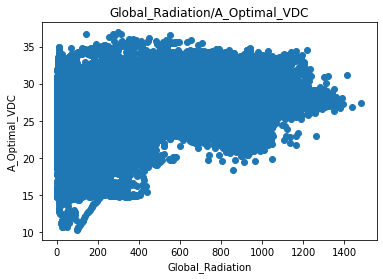

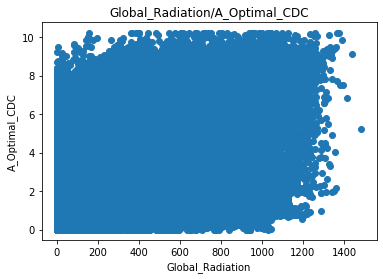

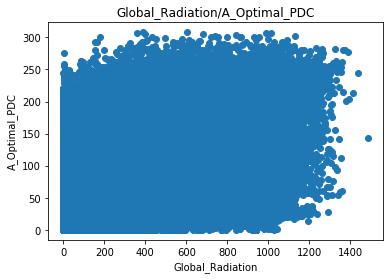

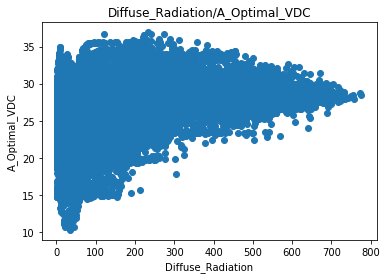

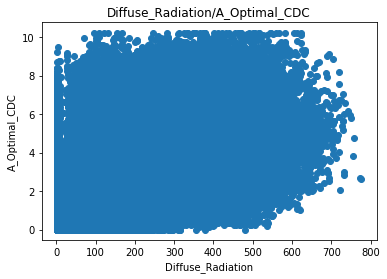

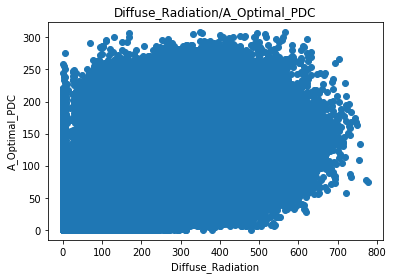

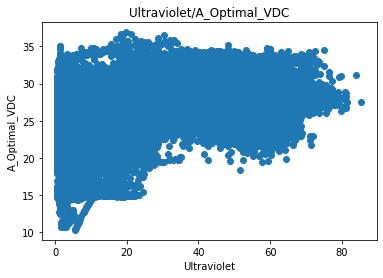

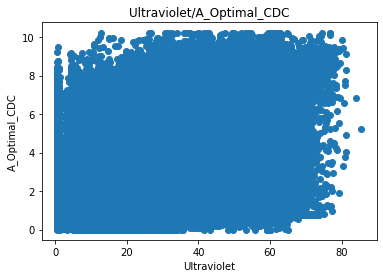

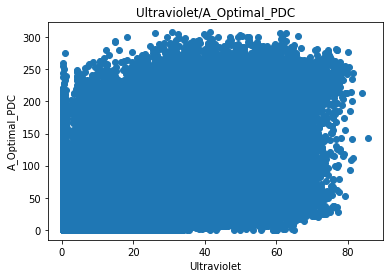

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Recorremos todos los features de entreda y los graficamos con los features de salida, uno por uno.
for nam_col in ['Global_Radiation', 'Diffuse_Radiation', 'Ultraviolet']:
    for nam_col2 in ['A_Optimal_VDC', 'A_Optimal_CDC', 'A_Optimal_PDC']:
            plt.scatter(train_dataset[nam_col], train_dataset[nam_col2])
            plt.title(nam_col+'/'+nam_col2)
            plt.xlabel(nam_col)
            plt.ylabel(nam_col2)
            plt.show()

## Creación de modelo de regresión lineal

### 1º- Modelo con datos en bruto.

Creamos un modelo de regresión lineal para cada una de las variables de salida. Luego testearemos el modelo final. No aplicaremos fase de validación por ser una regresión simple.

##### Importamos el modelo de regresión de SKlearn.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

### Modelo para el parámetro de tensión en corriente continua (VDC).

In [11]:
# Creación del modelo
reg_VDC = LinearRegression()

# Creamos el dataframe de resultados

result_VDC = test_dataset [['Datetime']]

# Entrenamiento del modelo. Se redondea la predicción a float de dos decimales
reg_VDC.fit(train_dataset[input_features], train_dataset[['A_Optimal_VDC']])
result_VDC['Predict_VDC'] = round(pd.DataFrame(reg_VDC.predict(test_dataset[input_features])), 2)

# Se introduce el resultado al data frame de resultados. Se añaden otras posibles métricas interesantes que nos
# aporten más información.

result_VDC['Real_VDC'] = test_dataset['A_Optimal_VDC']
result_VDC['Residual_VDC'] = round(result_VDC['Predict_VDC']-result_VDC['Real_VDC'], 2)
result_VDC['Resid_VDC_%'] = np.abs(result_VDC['Residual_VDC']/result_VDC['Real_VDC'])

result_VDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

,Datetime,Predict_VDC,Real_VDC,Residual_VDC,Resid_VDC_%
0,2017-07-16 14:19:00+00:00,28.41,24.40,4.01,0.164344
1,2017-06-07 16:33:00+00:00,27.63,27.95,-0.32,0.011449
2,2017-03-29 12:40:00+00:00,28.49,27.75,0.74,0.026667
3,2014-08-16 15:02:00+00:00,27.87,26.55,1.32,0.049718
4,2016-01-16 10:42:00+00:00,27.85,29.95,-2.10,0.070117


##### Métricas del modelo: MAE y R2

Debido a su robustez, el MAE ha sido la métrica seleccionada, ya que no se vé afectada por los posibles outlier que haya en el dataset de entranamiento.

In [12]:
print('MAE: ', np.mean(np.abs(result_VDC['Residual_VDC'])))
print('R^2: ', r2_score(result_VDC['Predict_VDC'],test_dataset['A_Optimal_VDC']))

MAE:  1.218412017437714
R^2:  -12.398478250136947


##### Graficamos el resultado

Gŕafica naran valor real, gráfica azul valor predicho.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

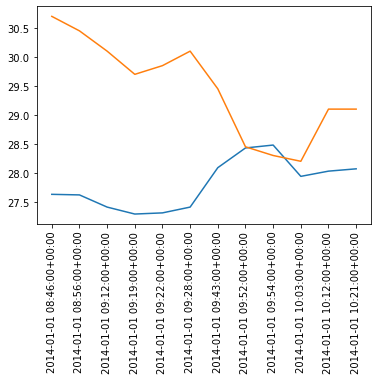

In [13]:
pd.to_datetime(result_VDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

result_VDC = result_VDC.sort_values('Datetime')

plt.plot(result_VDC['Datetime'].head(12), result_VDC['Predict_VDC'].head(12))
plt.plot(result_VDC['Datetime'].head(12), result_VDC['Real_VDC'].head(12))

plt.xticks(rotation='vertical')

### Modelo para el parámetro de corriente en corriente continua (CDC).

In [14]:
# Creación de modelo
reg_CDC = LinearRegression()

# Creamos el dataframe de resultados

result_CDC = test_dataset [['Datetime']]

# Entrenamiento de modelo
reg_CDC.fit(train_dataset[input_features], train_dataset[['A_Optimal_CDC']])
result_CDC['Predict_CDC'] = round(pd.DataFrame(reg_CDC.predict(test_dataset[input_features])), 2)

# Adición de resultados al dataframe de resultados.

result_CDC['Real_CDC'] = test_dataset['A_Optimal_CDC']
result_CDC['Residual_CDC'] = round(result_CDC['Predict_CDC']-result_CDC['Real_CDC'], 2)
result_CDC['Resid_CDC_%'] = np.abs(result_CDC['Residual_CDC']/result_CDC['Real_CDC'])

result_CDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,Datetime,Predict_CDC,Real_CDC,Residual_CDC,Resid_CDC_%
0,2017-07-16 14:19:00+00:00,5.89,6.3900,-0.50,0.078247
1,2017-06-07 16:33:00+00:00,3.22,3.2050,0.02,0.006240
2,2017-03-29 12:40:00+00:00,6.64,8.1500,-1.51,0.185276
3,2014-08-16 15:02:00+00:00,5.90,5.7925,0.11,0.018990
4,2016-01-16 10:42:00+00:00,4.09,6.4525,-2.36,0.365750


##### Métricas del modelo: MAE, MAPE y R2

In [15]:
print('MAE: ', np.mean(np.abs(result_CDC['Residual_CDC'])))
print('R^2: ', r2_score(result_CDC['Predict_CDC'],test_dataset['A_Optimal_CDC']))

MAE:  1.0616588549540986
R^2:  0.5301388725613105


#### Graficamos el resultado

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

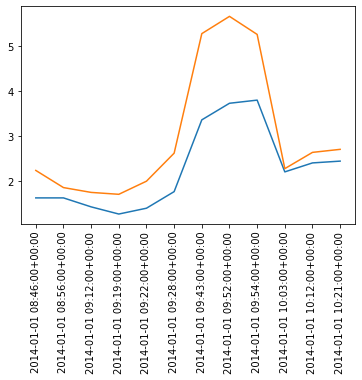

In [16]:
pd.to_datetime(result_CDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

result_CDC = result_CDC.sort_values('Datetime')

plt.plot(result_CDC['Datetime'].head(12), result_CDC['Predict_CDC'].head(12))
plt.plot(result_CDC['Datetime'].head(12), result_CDC['Real_CDC'].head(12))

plt.xticks(rotation='vertical')

### Modelo para el parámetro de potencia en corriente continua (PDC).

In [17]:
# Creación del modelo
reg_PDC = LinearRegression()

# Creamos el dataframe de resultados

result_PDC = test_dataset [['Datetime']]

# Entrenamiento del modelo
reg_PDC.fit(train_dataset[input_features], train_dataset[['A_Optimal_PDC']])
result_PDC['Predict_PDC'] = round(pd.DataFrame(reg_PDC.predict(test_dataset[input_features])), 2)

# Adición de resultado al dataframe de resultados
result_PDC['Real_PDC'] = test_dataset['A_Optimal_PDC']
result_PDC['Residual_PDC'] = round(result_PDC['Predict_PDC']-result_PDC['Real_PDC'], 2)
result_PDC['Resid_PDC_%'] = np.abs(result_PDC['Residual_PDC']/result_PDC['Real_PDC'])

result_PDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Datetime,Predict_PDC,Real_PDC,Residual_PDC,Resid_PDC_%
0,2017-07-16 14:19:00+00:00,165.13,155.916000,9.21,0.059070
1,2017-06-07 16:33:00+00:00,90.81,89.579750,1.23,0.013731
2,2017-03-29 12:40:00+00:00,185.76,226.162500,-40.40,0.178633
3,2014-08-16 15:02:00+00:00,164.13,153.790875,10.34,0.067234
4,2016-01-16 10:42:00+00:00,115.58,193.252375,-77.67,0.401910


##### Métricas del modelo: MAE y R2

In [18]:
print('MAE: ', np.mean(np.abs(result_PDC['Residual_PDC'])))
print('R^2: ', r2_score(result_PDC['Predict_PDC'],test_dataset['A_Optimal_PDC']))

MAE:  30.148130291805423
R^2:  0.5088388117989846


#### Graficamos el resultado

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

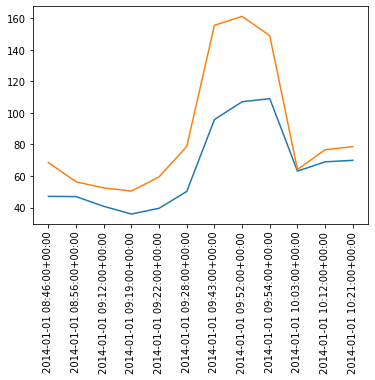

In [19]:
pd.to_datetime(result_PDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

result_PDC = result_PDC.sort_values('Datetime')

plt.plot(result_PDC['Datetime'].head(12), result_PDC['Predict_PDC'].head(12))
plt.plot(result_PDC['Datetime'].head(12), result_PDC['Real_PDC'].head(12))

plt.xticks(rotation='vertical')

### 2º- Datos normalizados

Debido a que las métricas nos dan valores muy malos, vamos a normalizar los datos de entrada para intentar mejorar los resultados.

In [0]:
from sklearn.preprocessing import MinMaxScaler

##### Normalizamos los valores de entrada de los dataset de train y test.

In [0]:
scaler_train = MinMaxScaler()
train_sc = scaler_train.fit_transform(train_dataset[input_features])
train_sc = pd.DataFrame(train_sc, columns=['Global_Radiation', 'Diffuse_Radiation','Ultraviolet'])

scaler_test = MinMaxScaler()
test_sc = scaler_test.fit_transform(test_dataset[input_features])
test_sc = pd.DataFrame(test_sc, columns=['Global_Radiation', 'Diffuse_Radiation', 'Ultraviolet'])

### Modelo para el parámetro de tensión en corriente continua (VDC).

In [22]:
# Creación de modelo
reg_VDC = LinearRegression()

# Creamos el dataframe de resultados

result_VDC = test_dataset [['Datetime']]

# Entrenamiento del modelo
reg_VDC.fit(train_sc, train_dataset[['A_Optimal_VDC']])
result_VDC['Predict_VDC'] = round(pd.DataFrame(reg_VDC.predict(test_sc[input_features])), 2)

# Adición de resultado al dataframe de resultados
result_VDC['Real_VDC'] = test_dataset['A_Optimal_VDC']
result_VDC['Residual_VDC'] = round(result_VDC['Predict_VDC']-result_VDC['Real_VDC'], 2)
result_VDC['Resid_VDC_%'] = np.abs(result_VDC['Residual_VDC']/result_VDC['Real_VDC'])

result_VDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Datetime,Predict_VDC,Real_VDC,Residual_VDC,Resid_VDC_%
0,2017-07-16 14:19:00+00:00,28.56,24.40,4.16,0.170492
1,2017-06-07 16:33:00+00:00,27.70,27.95,-0.25,0.008945
2,2017-03-29 12:40:00+00:00,28.65,27.75,0.90,0.032432
3,2014-08-16 15:02:00+00:00,28.00,26.55,1.45,0.054614
4,2016-01-16 10:42:00+00:00,27.93,29.95,-2.02,0.067446


##### Métricas del modelo: MAE, MAPE y R2

In [23]:
print('MAE: ', np.mean(np.abs(result_VDC['Residual_VDC'])))
print('R^2: ', r2_score(result_VDC['Predict_VDC'],test_dataset['A_Optimal_VDC']))

MAE:  1.2248388519302176
R^2:  -10.345483835657383


#### Graficamos el resultado

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

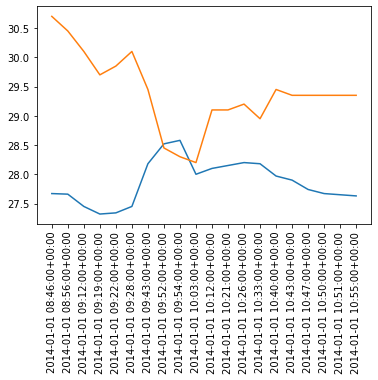

In [24]:
pd.to_datetime(result_VDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

result_VDC = result_VDC.sort_values('Datetime')

plt.plot(result_VDC['Datetime'].head(20), result_VDC['Predict_VDC'].head(20))
plt.plot(result_VDC['Datetime'].head(20), result_VDC['Real_VDC'].head(20))

plt.xticks(rotation='vertical')

### Modelo para el parámetro de corriente en corriente continua (CDC).

In [25]:
# Creación del modelo
reg_CDC = LinearRegression()

# Creamos el dataframe de resultados

result_CDC = test_dataset [['Datetime']]

# Entrenamiento del modelo
reg_CDC.fit(train_sc, train_dataset[['A_Optimal_CDC']])
result_CDC['Predict_CDC'] = round(pd.DataFrame(reg_CDC.predict(test_sc[input_features])), 2)

# Adición del resultado al dataframe de resultados
result_CDC['Real_CDC'] = test_dataset['A_Optimal_CDC']
result_CDC['Residual_CDC'] = round(result_CDC['Predict_CDC']-result_CDC['Real_CDC'], 2)
result_CDC['Resid_CDC_%'] = np.abs(result_CDC['Residual_CDC']/result_CDC['Real_CDC'])

result_CDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Datetime,Predict_CDC,Real_CDC,Residual_CDC,Resid_CDC_%
0,2017-07-16 14:19:00+00:00,6.20,6.3900,-0.19,0.029734
1,2017-06-07 16:33:00+00:00,3.37,3.2050,0.17,0.053042
2,2017-03-29 12:40:00+00:00,6.99,8.1500,-1.16,0.142331
3,2014-08-16 15:02:00+00:00,6.21,5.7925,0.42,0.072508
4,2016-01-16 10:42:00+00:00,4.29,6.4525,-2.16,0.334754


##### Métricas del modelo: MAE, MAPE y R2

In [26]:
print('MAE: ', np.mean(np.abs(result_CDC['Residual_CDC'])))
print('R^2: ', r2_score(result_CDC['Predict_CDC'],test_dataset['A_Optimal_CDC']))

MAE:  1.083544879548409
R^2:  0.5704554994408606


#### Graficamos el resultado

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

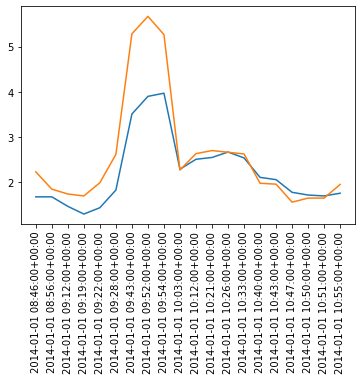

In [27]:
pd.to_datetime(result_CDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

result_CDC = result_CDC.sort_values('Datetime')

plt.plot(result_CDC['Datetime'].head(20), result_CDC['Predict_CDC'].head(20))
plt.plot(result_CDC['Datetime'].head(20), result_CDC['Real_CDC'].head(20))

plt.xticks(rotation='vertical')

### Modelo para el parámetro de potencia en corriente continua (PDC).

In [28]:
# Creación del modelo
reg_PDC = LinearRegression()

# Creamos el dataframe de resultados

result_PDC = test_dataset [['Datetime']]

# Entrenamiento del modelo al dataframe de resultados
reg_PDC.fit(train_sc, train_dataset[['A_Optimal_PDC']])
result_PDC['Predict_PDC'] = round(pd.DataFrame(reg_PDC.predict(test_sc[input_features])), 2)

# Adición de resultado
result_PDC['Real_PDC'] = test_dataset['A_Optimal_PDC']
result_PDC['Residual_PDC'] = round(result_PDC['Predict_PDC']-result_PDC['Real_PDC'], 2)
result_PDC['Resid_PDC_%'] = np.abs(result_PDC['Residual_PDC']/result_PDC['Real_PDC'])

result_PDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Datetime,Predict_PDC,Real_PDC,Residual_PDC,Resid_PDC_%
0,2017-07-16 14:19:00+00:00,174.05,155.916000,18.13,0.116281
1,2017-06-07 16:33:00+00:00,95.15,89.579750,5.57,0.062179
2,2017-03-29 12:40:00+00:00,195.94,226.162500,-30.22,0.133621
3,2014-08-16 15:02:00+00:00,173.09,153.790875,19.30,0.125495
4,2016-01-16 10:42:00+00:00,121.18,193.252375,-72.07,0.372932


##### Métricas del modelo: MAE, MAPE y R2

In [29]:
print('MAE: ', np.mean(np.abs(result_PDC['Residual_PDC'])))
print('R^2: ', r2_score(result_PDC['Predict_PDC'],test_dataset['A_Optimal_PDC']))

MAE:  30.976906624835145
R^2:  0.5524523821358515


#### Graficamos el resultado

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

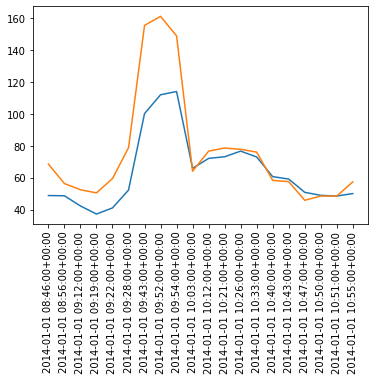

In [30]:
pd.to_datetime(result_PDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

result_PDC = result_PDC.sort_values('Datetime')

plt.plot(result_PDC['Datetime'].head(20), result_PDC['Predict_PDC'].head(20))
plt.plot(result_PDC['Datetime'].head(20), result_PDC['Real_PDC'].head(20))

plt.xticks(rotation='vertical')

### Conclusiónes sobre el modelo de regresión lineal

Como se puede observar, los datos mejoran considerablemente cuando se aplica normalización de los parámetros de entrada, sobretodo para las variables CDC y PDC.

La variable VDC, no posee ninguna relación lineal con el resto de valores de entrada, algo que se puede ver en la matriz de coeficientes de correlación de Pearson. Por lo tanto, dicha variable no se puede predecir mediante un modelo de regresión lineal. Probaremos si somos capaces de predecirla mediante otro modelo.

## Creación de modelo Arbol de decisión.

### Importamos las librerías necesarias para la creación del modelo

In [0]:
from sklearn.tree import DecisionTreeRegressor

#### Recuperamos los datos para evitar que hayan sido modificados en el proceso

In [32]:
train_dataset = pd.read_csv('train_dataset.csv',sep=';')
test_dataset = pd.read_csv('test_dataset.csv',sep=';')

# Datos de entrenamiento
train_dataset = train_dataset[['Datetime', 'Global_Radiation', 'Diffuse_Radiation', 
                              'Ultraviolet', 'A_Optimal_VDC', 'A_Optimal_CDC', 
                              'A_Optimal_PDC']]

# Datos test
test_dataset = test_dataset[['Datetime', 'Global_Radiation', 'Diffuse_Radiation', 
                              'Ultraviolet', 'A_Optimal_VDC', 'A_Optimal_CDC', 
                              'A_Optimal_PDC']]

pd.to_datetime(train_dataset['Datetime'], format="%Y-%m-%d %H:%M:%S")
pd.to_datetime(test_dataset['Datetime'], format="%Y-%m-%d %H:%M:%S")

0        2017-07-16 14:19:00+00:00
1        2017-06-07 16:33:00+00:00
2        2017-03-29 12:40:00+00:00
3        2014-08-16 15:02:00+00:00
4        2016-01-16 10:42:00+00:00
                    ...           
158731   2015-02-04 10:25:00+00:00
158732   2014-06-01 08:22:00+00:00
158733   2014-09-02 15:09:00+00:00
158734   2015-10-29 13:56:00+00:00
158735   2016-08-16 09:05:00+00:00
Name: Datetime, Length: 158736, dtype: datetime64[ns, UTC]

### Normalización de los datos

Debido a los resultados obtenidos en las pruebas anteriores, se procederá a trabajar directamente con los datos normalizados, ya que los resultados mejoran considerablemente.

In [0]:
scaler_train = MinMaxScaler()
train_sc = scaler_train.fit_transform(train_dataset[input_features])
train_sc = pd.DataFrame(train_sc, columns=['Global_Radiation', 'Diffuse_Radiation','Ultraviolet'])

scaler_test = MinMaxScaler()
test_sc = scaler_test.fit_transform(test_dataset[input_features])
test_sc = pd.DataFrame(test_sc, columns=['Global_Radiation', 'Diffuse_Radiation', 'Ultraviolet'])

### 1º- Creación de modelo de profundidad 3

Inicialmente, probaremos con el modelo de 3 capas para ver si los resultados mejoran frente al modelo de regresión lineal. Luego, intentaremos regularizar el modelo, buscando cuales son los parámetros más óptimos para el mismo.

### Modelo para el parámetro de tensión en corriente continua (VDC).

In [34]:
# Creación del modelo
regd_VDC = DecisionTreeRegressor(max_depth=3)

# Creamos el dataframe de resultados

resultD_VDC = test_dataset [['Datetime']]

# Entrenamiento del modelo
regd_VDC.fit(train_sc, train_dataset[['A_Optimal_VDC']])
resultD_VDC['Predict_VDC'] = round(pd.DataFrame(regd_VDC.predict(test_sc[input_features])), 2)

# Adición del resultado al dataframe de resultados
resultD_VDC['Real_VDC'] = test_dataset['A_Optimal_VDC']
resultD_VDC['Residual_VDC'] = round(resultD_VDC['Predict_VDC']-resultD_VDC['Real_VDC'], 2)
resultD_VDC['Resid_VDC_%'] = np.abs(resultD_VDC['Residual_VDC']/resultD_VDC['Real_VDC'])

resultD_VDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Datetime,Predict_VDC,Real_VDC,Residual_VDC,Resid_VDC_%
0,2017-07-16 14:19:00+00:00,28.01,24.40,3.61,0.147951
1,2017-06-07 16:33:00+00:00,28.04,27.95,0.09,0.003220
2,2017-03-29 12:40:00+00:00,28.01,27.75,0.26,0.009369
3,2014-08-16 15:02:00+00:00,28.04,26.55,1.49,0.056121
4,2016-01-16 10:42:00+00:00,28.04,29.95,-1.91,0.063773


##### Métricas del modelo: MAE,  R2 y Correlación

In [35]:
print('MAE: ', np.mean(np.abs(resultD_VDC['Residual_VDC'])))
print('R^2: ', r2_score(resultD_VDC['Predict_VDC'],test_dataset['A_Optimal_VDC']))
print('Correlation: ', np.corrcoef(resultD_VDC['Predict_VDC'],test_dataset['A_Optimal_VDC'])[0][1])

MAE:  1.1607814862412555
R^2:  -4.361582781992827
Correlation:  0.3962412719474636


#### Graficamos el resultado

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

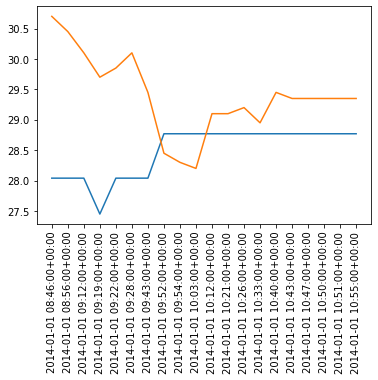

In [36]:
pd.to_datetime(resultD_VDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

resultD_VDC = resultD_VDC.sort_values('Datetime')

plt.plot(resultD_VDC['Datetime'].head(20), resultD_VDC['Predict_VDC'].head(20))
plt.plot(resultD_VDC['Datetime'].head(20), resultD_VDC['Real_VDC'].head(20))

plt.xticks(rotation='vertical')

### Modelo para el parámetro de corriente en corriente continua (CDC).

In [37]:
# Creación del modelo
regd_CDC = DecisionTreeRegressor(max_depth=3)

# Creamos el dataframe de resultados

resultD_CDC = test_dataset [['Datetime']]

# Entrenamiento del modelo
regd_CDC.fit(train_sc, train_dataset[['A_Optimal_CDC']])
resultD_CDC['Predict_CDC'] = round(pd.DataFrame(regd_CDC.predict(test_sc[input_features])), 2)

# Adición de resultado al dataframe de resultados y otras medidas que aporten información
resultD_CDC['Real_CDC'] = test_dataset['A_Optimal_CDC']
resultD_CDC['Residual_CDC'] = round(resultD_CDC['Predict_CDC']-resultD_CDC['Real_CDC'], 2)
resultD_CDC['Resid_CDC_%'] = np.abs(resultD_CDC['Residual_CDC']/resultD_CDC['Real_CDC'])

resultD_CDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Datetime,Predict_CDC,Real_CDC,Residual_CDC,Resid_CDC_%
0,2017-07-16 14:19:00+00:00,6.38,6.3900,-0.01,0.001565
1,2017-06-07 16:33:00+00:00,3.16,3.2050,-0.04,0.012480
2,2017-03-29 12:40:00+00:00,6.38,8.1500,-1.77,0.217178
3,2014-08-16 15:02:00+00:00,6.38,5.7925,0.59,0.101856
4,2016-01-16 10:42:00+00:00,4.98,6.4525,-1.47,0.227819


##### Métricas del modelo: MAE,  R2 y Correlación

In [38]:
print('MAE: ', np.mean(np.abs(resultD_CDC['Residual_CDC'])))
print('R^2: ', r2_score(resultD_CDC['Predict_CDC'],test_dataset['A_Optimal_CDC']))
print('Correlation: ', np.corrcoef(resultD_CDC['Predict_CDC'],test_dataset['A_Optimal_CDC'])[0][1])

MAE:  1.069874886604119
R^2:  0.5507612062464335
Correlation:  0.8285378871895372


#### Graficamos el resultado

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

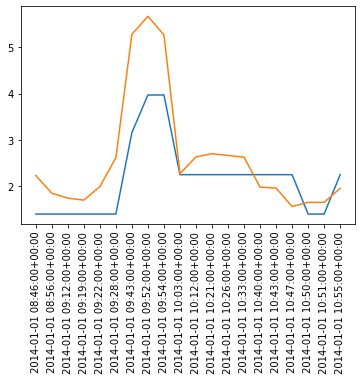

In [39]:
pd.to_datetime(resultD_CDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

resultD_CDC = resultD_CDC.sort_values('Datetime')

plt.plot(resultD_CDC['Datetime'].head(20), resultD_CDC['Predict_CDC'].head(20))
plt.plot(resultD_CDC['Datetime'].head(20), resultD_CDC['Real_CDC'].head(20))

plt.xticks(rotation='vertical')

### Modelo para el parámetro de potencia en corriente continua (PDC).

In [40]:
# Creeamos el modelo
regd_PDC = DecisionTreeRegressor(max_depth=3)

# Creamos el dataframe de resultados

resultD_PDC = test_dataset [['Datetime']]

# Entrenamos el modelo
regd_PDC.fit(train_sc, train_dataset[['A_Optimal_PDC']])
resultD_PDC['Predict_PDC'] = round(pd.DataFrame(regd_PDC.predict(test_sc[input_features])), 2)

# Adición del resultado al dataframe de resultados
resultD_PDC['Real_PDC'] = test_dataset['A_Optimal_PDC']
resultD_PDC['Residual_PDC'] = round(resultD_PDC['Predict_PDC']-resultD_PDC['Real_PDC'], 2)
resultD_PDC['Resid_PDC_%'] = np.abs(resultD_PDC['Residual_PDC']/resultD_PDC['Real_PDC'])

resultD_PDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Datetime,Predict_PDC,Real_PDC,Residual_PDC,Resid_PDC_%
0,2017-07-16 14:19:00+00:00,176.76,155.916000,20.84,0.133662
1,2017-06-07 16:33:00+00:00,111.21,89.579750,21.63,0.241461
2,2017-03-29 12:40:00+00:00,176.76,226.162500,-49.40,0.218427
3,2014-08-16 15:02:00+00:00,176.76,153.790875,22.97,0.149359
4,2016-01-16 10:42:00+00:00,140.16,193.252375,-53.09,0.274718


##### Métricas del modelo: MAE, R2 y Correlación

In [41]:
print('MAE: ', np.mean(np.abs(resultD_PDC['Residual_PDC'])))
print('R^2: ', r2_score(resultD_PDC['Predict_PDC'],test_dataset['A_Optimal_PDC']))
print('Correlation: ', np.corrcoef(resultD_PDC['Predict_PDC'],test_dataset['A_Optimal_PDC'])[0][1])

MAE:  29.941477043645413
R^2:  0.536844816623202
Correlation:  0.8243693797607139


#### Graficamos el resultado

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

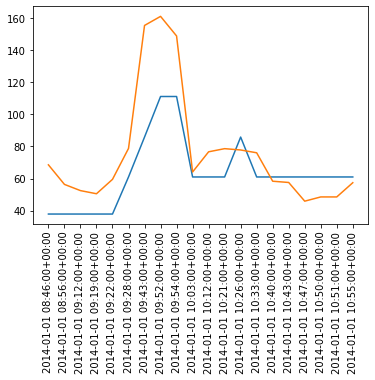

In [42]:
pd.to_datetime(resultD_PDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

resultD_PDC = resultD_PDC.sort_values('Datetime')

plt.plot(resultD_PDC['Datetime'].head(20), resultD_PDC['Predict_PDC'].head(20))
plt.plot(resultD_PDC['Datetime'].head(20), resultD_PDC['Real_PDC'].head(20))

plt.xticks(rotation='vertical')

### 2º- Optimización de hiperparámetros.

Tras probar el modelo básico de 3 capas, buscamos mejorar el modelo optimizando los hiperparametros.

##### Importamos librerías

In [0]:
from sklearn.model_selection import GridSearchCV

### Modelo para el parámetro de tensión en corriente continua (VDC).

In [44]:
# Creación del modelo
regDG_VDC = GridSearchCV(DecisionTreeRegressor(),
                        param_grid = {"max_depth": np.arange(9, 13),
                                      "min_samples_split": [100, 110, 120, 130],
                                      "min_samples_leaf": [80, 90, 100, 110]
                        },cv = 5,
                        scoring = "neg_mean_absolute_error")

# Entrenamiento del modelo
regDG_VDC.fit(train_sc, train_dataset[['A_Optimal_VDC']])


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 9, 10, 11, 12]),
                         'min_samples_leaf': [80, 90, 100, 110],
                         'm

In [45]:
regDG_VDC.best_params_

{'max_depth': 12, 'min_samples_leaf': 80, 'min_samples_split': 110}

In [46]:
regDG_VDC.best_score_

-1.0990617693995424

In [47]:
# Creamos el dataframe de resultados
resultDG_VDC = test_dataset [['Datetime']]

resultDG_VDC['Predict_VDC'] = pd.DataFrame(regDG_VDC.best_estimator_.predict(test_sc[input_features]))

resultDG_VDC['Real_VDC'] = test_dataset['A_Optimal_VDC']
resultDG_VDC['Residual_VDC'] = round(resultDG_VDC['Predict_VDC']-resultDG_VDC['Real_VDC'],2)
resultDG_VDC['Resid_VDC_%'] = np.abs(resultDG_VDC['Residual_VDC']/resultDG_VDC['Real_VDC'])

resultDG_VDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,Datetime,Predict_VDC,Real_VDC,Residual_VDC,Resid_VDC_%
0,2017-07-16 14:19:00+00:00,27.745463,24.40,3.35,0.137295
1,2017-06-07 16:33:00+00:00,28.764231,27.95,0.81,0.028980
2,2017-03-29 12:40:00+00:00,28.122978,27.75,0.37,0.013333
3,2014-08-16 15:02:00+00:00,27.360904,26.55,0.81,0.030508
4,2016-01-16 10:42:00+00:00,28.343684,29.95,-1.61,0.053756


##### Métricas del modelo: MAE, MAPE, R2 y Correlación

In [48]:
print('error absoluto medio: ', mean_absolute_error(resultDG_VDC['Predict_VDC'],resultDG_VDC['Real_VDC']))
print('parametro R2: ', r2_score(resultDG_VDC['Predict_VDC'],test_dataset['A_Optimal_VDC']))
print('Correlation: ', np.corrcoef(resultDG_VDC['Predict_VDC'],test_dataset['A_Optimal_VDC'])[0][1])

error absoluto medio:  1.0990706831673915
parametro R2:  -2.4363304313504144
Correlation:  0.4478778945369845


#### Graficamos el modelo

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

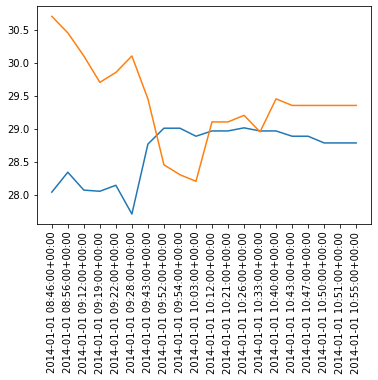

In [49]:
pd.to_datetime(resultDG_VDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

resultDG_VDC = resultDG_VDC.sort_values('Datetime')

plt.plot(resultDG_VDC['Datetime'].head(20), resultDG_VDC['Predict_VDC'].head(20))
plt.plot(resultDG_VDC['Datetime'].head(20), resultDG_VDC['Real_VDC'].head(20))

plt.xticks(rotation='vertical')

### Modelo para el parámetro de corriente en corriente continua (CDC).

In [50]:
# Creación del modelo por GridSeachCV

regDG_CDC = GridSearchCV(DecisionTreeRegressor(),
                        param_grid = {"max_depth": np.arange(9, 13),
                                      "min_samples_split": [60,70,80,90],
                                      "min_samples_leaf": [30,40,50,60]
                        },cv = 5,
                        scoring = "neg_mean_absolute_error")

# Entrenamiento del modelo
regDG_CDC.fit(train_sc, train_dataset[['A_Optimal_CDC']])

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 9, 10, 11, 12]),
                         'min_samples_leaf': [30, 40, 50, 60],
                         'min

In [51]:
regDG_CDC.best_params_

{'max_depth': 12, 'min_samples_leaf': 30, 'min_samples_split': 70}

In [52]:
regDG_CDC.best_score_

-0.9431940155022647

In [53]:
# Creamos el dataframe de resultados
resultDG_CDC = test_dataset [['Datetime']]

resultDG_CDC['Predict_CDC'] = pd.DataFrame(regDG_CDC.best_estimator_.predict(test_sc[input_features]))

resultDG_CDC['Real_CDC'] = test_dataset['A_Optimal_CDC']
resultDG_CDC['Residual_CDC'] = round(resultDG_CDC['Predict_CDC']-resultDG_CDC['Real_CDC'],2)
resultDG_CDC['Resid_CDC_%'] = np.abs(resultDG_CDC['Residual_CDC']/resultDG_CDC['Real_CDC'])

resultDG_CDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,Datetime,Predict_CDC,Real_CDC,Residual_CDC,Resid_CDC_%
0,2017-07-16 14:19:00+00:00,6.922785,6.3900,0.53,0.082942
1,2017-06-07 16:33:00+00:00,3.066190,3.2050,-0.14,0.043682
2,2017-03-29 12:40:00+00:00,6.488747,8.1500,-1.66,0.203681
3,2014-08-16 15:02:00+00:00,6.876816,5.7925,1.08,0.186448
4,2016-01-16 10:42:00+00:00,4.276429,6.4525,-2.18,0.337854


##### Métricas del modelo: MAE, MAPE, R2 y Correlación

In [54]:
print('error absoluto medio: ', mean_absolute_error(resultDG_CDC['Predict_CDC'],resultDG_CDC['Real_CDC']))
print('parametro R2: ', r2_score(resultDG_CDC['Predict_CDC'],test_dataset['A_Optimal_CDC']))
print('Correlation: ', np.corrcoef(resultDG_CDC['Predict_CDC'],test_dataset['A_Optimal_CDC'])[0][1])

error absoluto medio:  0.9818751068818212
parametro R2:  0.6357101892787432
Correlation:  0.8449362265368587


#### Graficamos el modelo

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

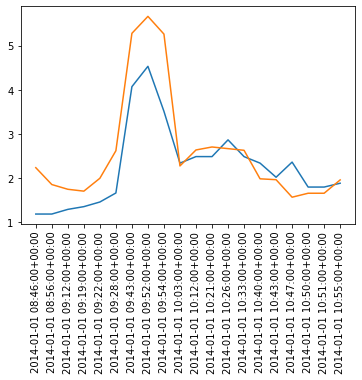

In [55]:
pd.to_datetime(resultDG_CDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

resultDG_CDC = resultDG_CDC.sort_values('Datetime')

plt.plot(resultDG_CDC['Datetime'].head(20), resultDG_CDC['Predict_CDC'].head(20))
plt.plot(resultDG_CDC['Datetime'].head(20), resultDG_CDC['Real_CDC'].head(20))

plt.xticks(rotation='vertical')

### Modelo para el parámetro de potencia en corriente continua (PDC).

In [56]:
# Creación del modelo por GridSeachCV

regDG_PDC = GridSearchCV(DecisionTreeRegressor(),
                        param_grid = {"max_depth": np.arange(9, 13),
                                      "min_samples_split": [60,70,80,90],
                                      "min_samples_leaf": [30,40,50,60]
                        },cv = 5,
                        scoring = "neg_mean_absolute_error")

# Entrenamiento del modelo
regDG_PDC.fit(train_sc, train_dataset[['A_Optimal_PDC']])

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 9, 10, 11, 12]),
                         'min_samples_leaf': [30, 40, 50, 60],
                         'min

In [57]:
regDG_PDC.best_params_

{'max_depth': 12, 'min_samples_leaf': 30, 'min_samples_split': 60}

In [58]:
regDG_PDC.best_score_

-26.225930596802705

In [59]:
# Creamos el dataframe de resultados
resultDG_PDC = test_dataset [['Datetime']]

resultDG_PDC['Predict_PDC'] = pd.DataFrame(regDG_PDC.best_estimator_.predict(test_sc[input_features]))

resultDG_PDC['Real_PDC'] = test_dataset['A_Optimal_PDC']
resultDG_PDC['Residual_PDC'] = round(resultDG_PDC['Predict_PDC']-resultDG_PDC['Real_PDC'],2)
resultDG_PDC['Resid_PDC_%'] = np.abs(resultDG_PDC['Residual_PDC']/resultDG_PDC['Real_PDC'])

resultDG_PDC.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,Datetime,Predict_PDC,Real_PDC,Residual_PDC,Resid_PDC_%
0,2017-07-16 14:19:00+00:00,180.091523,155.916000,24.18,0.155084
1,2017-06-07 16:33:00+00:00,67.827219,89.579750,-21.75,0.242800
2,2017-03-29 12:40:00+00:00,176.787372,226.162500,-49.38,0.218339
3,2014-08-16 15:02:00+00:00,198.656665,153.790875,44.87,0.291760
4,2016-01-16 10:42:00+00:00,122.362061,193.252375,-70.89,0.366826


##### Métricas del modelo: MAE, MAPE, R2 y Correlación

In [60]:
print('error absoluto medio: ', mean_absolute_error(resultDG_PDC['Predict_PDC'],resultDG_PDC['Real_PDC']))
print('parametro R2: ', r2_score(resultDG_PDC['Predict_PDC'],test_dataset['A_Optimal_PDC']))
print('Correlation: ', np.corrcoef(resultDG_PDC['Predict_PDC'],test_dataset['A_Optimal_PDC'])[0][1])

error absoluto medio:  27.35871747801742
parametro R2:  0.6280648340252443
Correlation:  0.8427917450338039


#### Graficamos el modelo

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

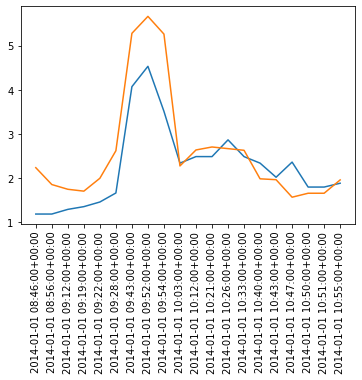

In [61]:
pd.to_datetime(resultDG_CDC['Datetime'], format="%Y-%m-%d %H:%M:%S")

resultDG_CDC = resultDG_CDC.sort_values('Datetime')

plt.plot(resultDG_CDC['Datetime'].head(20), resultDG_CDC['Predict_CDC'].head(20))
plt.plot(resultDG_CDC['Datetime'].head(20), resultDG_CDC['Real_CDC'].head(20))

plt.xticks(rotation='vertical')

### Guardando los modelos

Atendiendo a las métricas de la verificación, hemos escogido para cada parámetro a predecir el modelo que menor error mostraba.

In [0]:
import pickle

pickle.dump(regDG_VDC.best_estimator_,open("regDG_VDC.pickle","wb"))
pickle.dump(regDG_CDC.best_estimator_,open("regDG_CDC.pickle","wb"))
pickle.dump(regDG_PDC.best_estimator_,open("regDG_PDC.pickle","wb"))